In [1]:
# Mengimpor library
import re
import locale

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from joblib import Parallel
from joblib import delayed

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, ConfusionMatrixDisplay

## Data Understanding

In [2]:
# Menyiapkan format bahasa dan mengunduh dictionary
locale.setlocale(locale.LC_ALL, '')
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to /home/fahmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fahmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Kumpulan stopwords
stopwords_list = set(stopwords.words('english') + ['AT_USER', 'URL'])
stemmer = SnowballStemmer(language='english')

In [4]:
# membaca data dari file CSV
df = pd.read_csv(r'../datasets/imdb-reviews-50k.csv.gz')

In [5]:
# menampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# Menampilkan sampel data
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:>

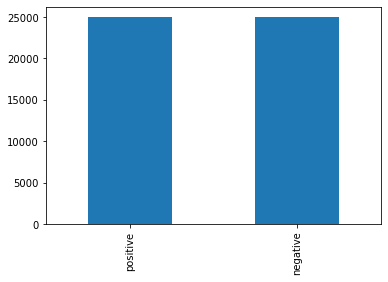

In [7]:
# Menghitung banyaknya data untuk setiap kelas
df["sentiment"].value_counts().plot(kind="bar")

## Data Preparation

In [8]:
# Fungsi untuk melakukan pembersihan teks
def preprocess_text(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'AT_USER', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stopwords_list and word.isalpha()]
    text = [stemmer.stem(word) for word in text]
    return ' '.join(text)

In [9]:
y = df["sentiment"].values
X = Parallel(n_jobs=4, batch_size=64, verbose=10)(delayed(preprocess_text)(text) for text in df["review"].values)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 328 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 648 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1096 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1544 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 2120 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 2696 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 4104 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 4936 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 5768 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 6728 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 7688 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 8776 tasks      | elapsed:    6.5s

[('br', 201927), ('movi', 99850), ('film', 92714), ('one', 53625), ('like', 44186), ('time', 30080), ('good', 29194), ('make', 28639), ('see', 27793), ('charact', 27770)]


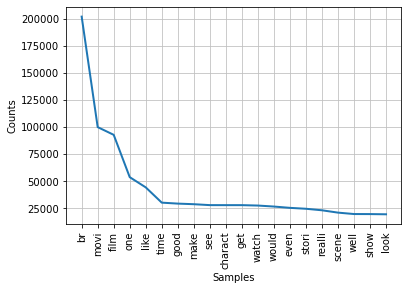

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [10]:
# Membuat korpus kata-kata umum
freqdist = FreqDist()
for sentence in X:
    for word in word_tokenize(sentence):
        freqdist[word] += 1

# Visualisasi kata-kata umum
print(freqdist.most_common(10))
freqdist.plot(20, cumulative=False)

In [11]:
# Membagi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [12]:
# Fungsi untuk mengubah id 4 menjadi 1 dan sisanya 0
lb = LabelEncoder()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

## Modelling

In [13]:
# Membuat model
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(use_idf=True)),
    ('clf', MultinomialNB())
])

classifier.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Evaluation

In [14]:
# Melakukan prediksi menggunakan data uji
y_pred = classifier.predict(X_test)

print("Kappa score:", cohen_kappa_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=lb.classes_))

Kappa score: 0.7128484848484848
              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      8250
    positive       0.86      0.84      0.85      8250

    accuracy                           0.86     16500
   macro avg       0.86      0.86      0.86     16500
weighted avg       0.86      0.86      0.86     16500



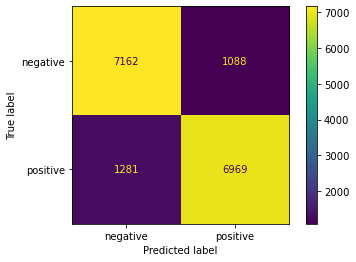

In [15]:
# Membuat confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=lb.classes_)

## Prediction

In [16]:
# Lakukan pediksi satu kalimat
pred_text = ["this painting is excellent", "you're horrible person!"]
pred_input = [preprocess_text(x) for x in pred_text]

# Prediksi kelas
predictions = classifier.predict(pred_input)
predictions_classes = lb.inverse_transform(predictions)

for text, sentiment in zip(pred_text, predictions_classes):
    print(text, "=", sentiment)

this painting is excellent = positive
you're horrible person! = negative
